# Adaptive normalization

This Jupyter notebook presents the entire code to use the adaptive normalization technique.

First, we describe the preliminary code that is used by the technique. 

Then, the actual adaptive normalization code is presented.

Finally, a complete example is presented.


## Preliminary code

This section contains some preliminary code used by Adaptive normalization.

Function $ts\_sw$ converts a time series into a overlapped sliding windows of size $sw\_size$.

In [77]:
ts_sw <- function(x, sw_size) {
  ts_lag <- function(x, k) 
  {
    c(rep(NA, k), x)[1 : length(x)] 
  }
  n <- length(x)-sw_size+1
  sw <- NULL
  for(c in (sw_size-1):0){
    t  <- ts_lag(x,c)
    t <- t[sw_size:length(t)]
    sw <- cbind(sw,t,deparse.level = 0)
  }
  col <- paste("t",c((sw_size-1):0), sep="")
  #rownames(sw) <- NULL
  colnames(sw) <- col
  return(sw)  
}

Function $ts\_as\_matrix$ projects sliding window $sw$. If $sw$ contains more lagged elements than $size$, older lags are removed.

In [78]:
ts_as_matrix <- function(sw, size) {
  sw <- data.frame(sw)
  sw <- sw[, (ncol(sw)-size+1):ncol(sw)]
  sw <- as.matrix(sw)
  return(sw)
}

Function $ts\_train\_test$ converts sliding window $sw$ into training and testing. 

In [79]:
ts_train_test <- function(x, test_size, sw_size = 0, offset=0) {
  if (offset == 0) {
    offset <- length(x)-test_size
  }
  if (sw_size == 0) {
    train <- x[1:offset]
    test <- x[(offset+1):(offset+test_size)]
  }
  else {
    train <- x[1:offset]
    test <- x[(offset-(sw_size-1)+1):(offset+test_size)]
    train <- ts_sw(train, sw_size)
    test <- ts_sw(test, sw_size)
  }
  return(list(train=train, test=test))
}

Function $ts\_sw\_project$ splits sliding window $sw$ into input ($t_n$ to $t_2$) and output ($t_1$). 

In [80]:
ts_sw_project <- function(sw) 
{
  if (is.vector(sw)) {
    input <- sw
    output <- sw
  }
  else {
    input <- sw[,1:ncol(sw)-1]
    output <- sw[,ncol(sw)]
  }
  return (list(input=input, output=output))
} 


Functions $outliers$ and $outliers\_remove$ are, respectively, used to identify and remove sliding windows that are outliers.

In [81]:
outliers <- function(data, alpha=1.5) {
  if(is.matrix(data) || is.data.frame(data)) {
    idx = rep(FALSE, nrow(data))
    org <- nrow(data)
    data <- as.data.frame(data)
    if (org >= 30) {
      isnumeric = (ifelse(sapply(data, is.numeric), TRUE, FALSE))
      data <- data[,as.vector(isnumeric)]
      q <- sapply(data, quantile, na.rm=TRUE)
      n <- ncol(data)
      for (i in 1:n)
      {
        IQR <- q[4,i] - q[2,i]
        lq1 <- q[2,i] - alpha*IQR
        hq3 <- q[4,i] + alpha*IQR
        idx = idx | (!is.na(data[,i]) & (data[,i] < lq1 | data[,i] > hq3))
      }
    }
    return(idx)
  }
  else {
    idx <- rep(FALSE, length(data))
    if (length(data) >= 30) {
      q <- quantile(data)
      IQR <- q[4] - q[2]
      lq1 <- q[2] - obj$alpha*IQR
      hq3 <- q[4] + obj$alpha*IQR
      idx <- data < lq1 | data > hq3
    }
    return (idx) 
  } 
}

In [82]:
outliers_remove <- function(data)
{
  idx <- outliers(data)
  if(is.matrix(data) || is.data.frame(data)) {
    return(data[!idx,])
  }
  else {
    return(data[!idx])
  } 
}

## Adaptive normalization main code

Functions $ts\_inertia$, $ts\_remove\_inertia$, and $ts\_add\_inertia$ respectively compute, remove, and add inertia into the sliding windows $x$. 

In [83]:
an_inertia <- function(x) {
  an <- apply(x, 1, mean)
  return(an)
}

an_remove_inertia <- function(x, an) {
  return(x / an)
}

an_add_inertia <- function(x, an) {
  return(x * an)
}

Function $AN\_setup$ extracts parameters from sliding window $x$ using training data. 
It computes the inertia $an$, removes the inertia of the sliding windows. 
Then, it removes the outliers. 
It computes global min/max on the adaptive normalization space. 

If $rescale$ is set, it adjusts the $scale$ and $offset$ considering the ratio of change from input data to output so that output data fits in the normalized range $0$ to $1$. 

Function $AN\_setup$ returns object $obj$ with normalized parameters. 

In [84]:
AN_setup <- function(x, rescale=TRUE) {
  obj <- list(sw_size <- ncol(x), rescale=rescale, offset=0, scale=1)
  
  an <- an_inertia(ts_sw_project(x)$input)
  x <- an_remove_inertia(x, an)
  x <- cbind(x, an)
  x <- outliers_remove(x)    
  x <- x[,1:(ncol(x)-1)]
  
  io <- ts_sw_project(x)
  
  obj$gmin <- min(io$input)
  obj$gmax <- max(io$input)
  
  if (obj$rescale) {
    ratio <- (obj$gmax-obj$gmin)/(max(x)-min(x))
    
    obj$offset <- obj$offset + (1 - ratio) * obj$scale / 2
    obj$scale <- obj$scale * ratio
  }
  return(obj)
}

Function $AN\_normalize$. It takes into account the previous normalized parameters $obj$. 
If $x$ corresponds to the input normalized sliding windows, it computes the inertia $an$ and returns both inertia and normalized sliding windows. 
If $x$ corresponds to the output vector, it uses previous saved inertia $an$ and computed parameters $obj$ to normalize $x$. 

In [85]:
AN_normalize <- function(obj, x, arguments=NULL) {
  # x can be either input matrix or output vector
  if (is.vector(x)) {
    an <- arguments$an
    x <- an_remove_inertia(x, an)
  }
  else {
    an <- an_inertia(x)
    x <- an_remove_inertia(x, an)
  }
  return (list(x=obj$scale*(x - obj$gmin)/(obj$gmax - obj$gmin) + obj$offset, arguments=list(an=an)))
}


Function $AN\_denormalize$ denormize $x$. Variable $x$ can be either a sliding window or a vector. It uses previously computed inertia $an$ and normalized parameters $obj$. 

In [86]:
AN_denormalize <- function(obj, x, arguments=NULL) {
  # x can be either input matrix or output vector
  x <- (x - obj$offset) * (obj$gmax - obj$gmin) / (obj$scale) + obj$gmin
  x <- an_add_inertia(x, arguments$an)
  return (list(x=x, arguments=arguments))
}


## Step by step 

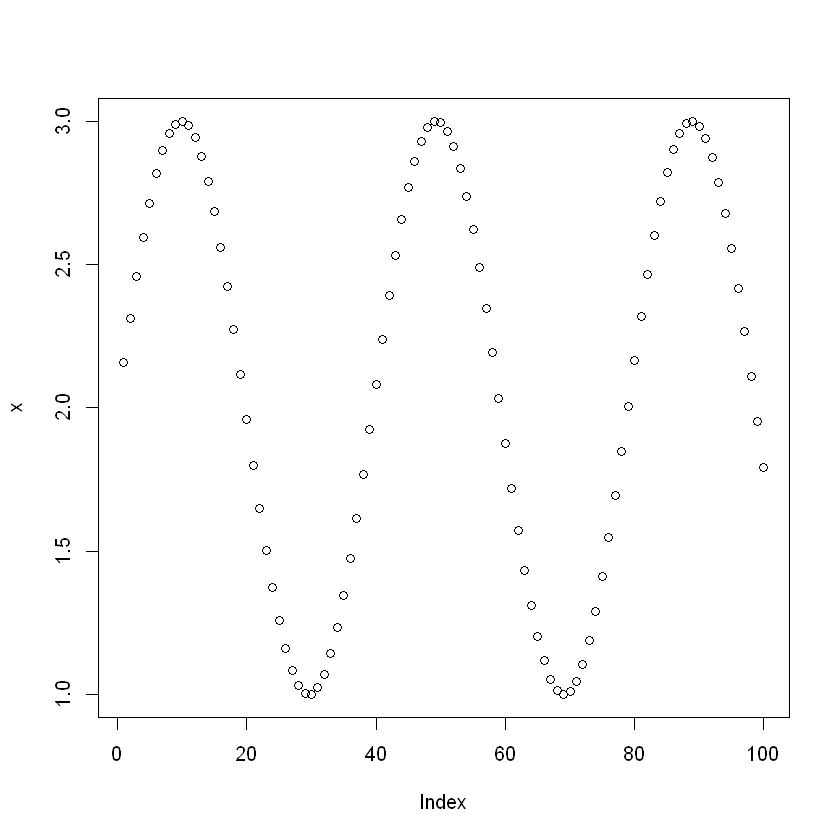

In [87]:
# load time series 
load_series <- function(name) {
  link <- url(sprintf("https://raw.githubusercontent.com/eogasawara/mylibrary/master/data/time-series/%s.RData", name))
  x <- get(load(link))
  return(x)  
}

x <- load_series("sin")
plot(x)

In [88]:
# splits dataset into train and test
tt <- ts_train_test(x, test_size=12, sw_size=10)
head(tt$train)
head(tt$test)

t9,t8,t7,t6,t5,t4,t3,t2,t1,t0
2.158484,2.312962,2.459529,2.594481,2.714406,2.816273,2.897507,2.956056,2.990438,2.999785
2.312962,2.459529,2.594481,2.714406,2.816273,2.897507,2.956056,2.990438,2.999785,2.983860
2.459529,2.594481,2.714406,2.816273,2.897507,2.956056,2.990438,2.999785,2.983860,2.943067
2.594481,2.714406,2.816273,2.897507,2.956056,2.990438,2.999785,2.983860,2.943067,2.878436
2.714406,2.816273,2.897507,2.956056,2.990438,2.999785,2.983860,2.943067,2.878436,2.791600
2.816273,2.897507,2.956056,2.990438,2.999785,2.983860,2.943067,2.878436,2.791600,2.684756


t9,t8,t7,t6,t5,t4,t3,t2,t1,t0
2.165263,2.319479,2.465620,2.599991,2.719196,2.820222,2.900516,2.958047,2.991362,2.999619
2.319479,2.465620,2.599991,2.719196,2.820222,2.900516,2.958047,2.991362,2.999619,2.982608
2.465620,2.599991,2.719196,2.820222,2.900516,2.958047,2.991362,2.999619,2.982608,2.940760
2.599991,2.719196,2.820222,2.900516,2.958047,2.991362,2.999619,2.982608,2.940760,2.875132
2.719196,2.820222,2.900516,2.958047,2.991362,2.999619,2.982608,2.940760,2.875132,2.787384
2.820222,2.900516,2.958047,2.991362,2.999619,2.982608,2.940760,2.875132,2.787384,2.679733


In [89]:
# AN_setup extracts AN parameters
AN <- AN_setup(tt$train)
AN

[[1]]
[1] 10

$rescale
[1] TRUE

$offset
[1] 0.09722791

$scale
[1] 0.8055442

$gmin
[1] 0.690824

$gmax
[1] 1.375037

In [90]:
# split sliding training data into input and output
io <- ts_sw_project(tt$train)
head(io$input)
head(io$output)

t9,t8,t7,t6,t5,t4,t3,t2,t1
2.158484,2.312962,2.459529,2.594481,2.714406,2.816273,2.897507,2.956056,2.990438
2.312962,2.459529,2.594481,2.714406,2.816273,2.897507,2.956056,2.990438,2.999785
2.459529,2.594481,2.714406,2.816273,2.897507,2.956056,2.990438,2.999785,2.983860
2.594481,2.714406,2.816273,2.897507,2.956056,2.990438,2.999785,2.983860,2.943067
2.714406,2.816273,2.897507,2.956056,2.990438,2.999785,2.983860,2.943067,2.878436
2.816273,2.897507,2.956056,2.990438,2.999785,2.983860,2.943067,2.878436,2.791600


[1] 2.999785 2.983860 2.943067 2.878436 2.791600 2.684756

In [91]:
# normalize input data for training. 
input <- AN_normalize(AN,io$input)
head(input$x)

t9,t8,t7,t6,t5,t4,t3,t2,t1
0.2408500,0.3093367,0.3743164,0.4341464,0.4873144,0.5324765,0.5684913,0.5944482,0.6096913
0.2744681,0.3372382,0.3950337,0.4463938,0.4900203,0.5248104,0.5498847,0.5646095,0.5686125
0.3094295,0.3656992,0.4157034,0.4581781,0.4920498,0.5164621,0.5307981,0.5346954,0.5280555
0.3454994,0.3945699,0.4362516,0.4694907,0.4934472,0.5075156,0.5113401,0.5048242,0.4881325
0.3825233,0.4237528,0.4566314,0.4803281,0.4942438,0.4980269,0.4915816,0.4750710,0.4489123
0.4204017,0.4531836,0.4768107,0.4906855,0.4944574,0.4880311,0.4715690,0.4454872,0.4104450


In [92]:
# normalize output data for training - see that input$arguments is passing the inertia an. 
output <- AN_normalize(AN, io$output, arguments=input$arguments)
head(output$x)

[1] 0.6138352 0.5617925 0.5110462 0.4616869 0.4137667 0.3673281

In [93]:
# check the scale of input to output
print(sprintf("i=[%.3f,%.3f] - o=[%.3f,%.3f]", min(input$x), max(input$x), min(output$x), max(output$x)))

[1] "i=[0.097,0.903] - o=[0.036,1.036]"


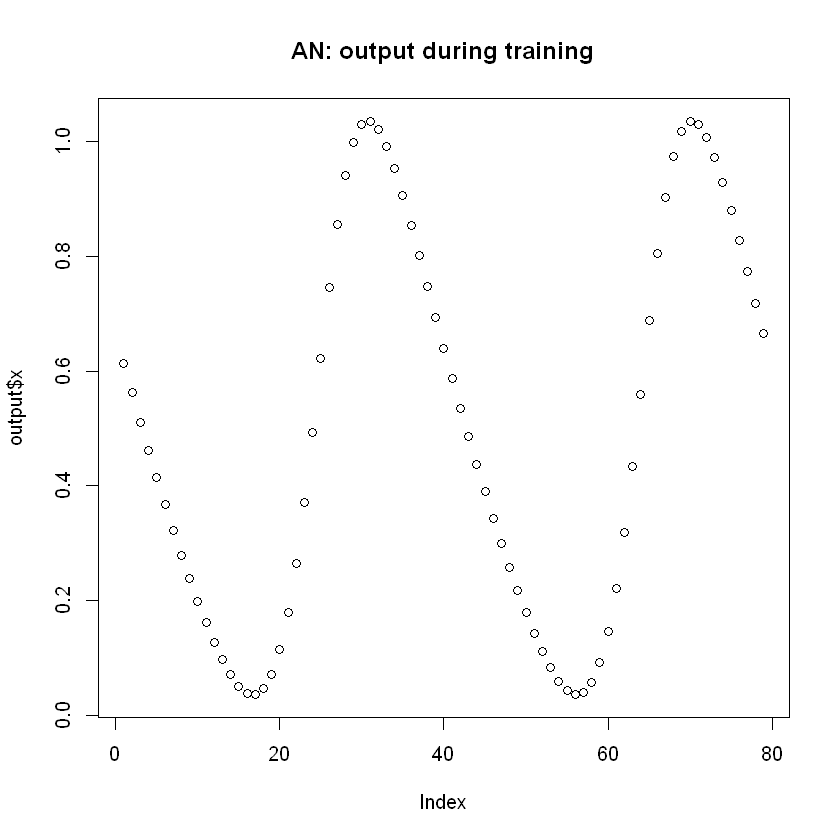

In [94]:
# check normalization of output used during training. Later try to increase sw_size in the beginning to see the effect. 
plot(output$x, main="AN: output during training")

In [95]:
# denormilize training data just to see if it is working. 
input_org <- AN_denormalize(AN, input$x, arguments=input$arguments)
output_org <- AN_denormalize(AN, output$x, arguments=input$arguments)
print(sprintf("i=%.3f - o=%.3f", abs(mean(input_org$x-io$input)), abs(mean(output_org$x-io$output))))

[1] "i=0.000 - o=0.000"


In [96]:
#train a neural network model using last five lags
library(nnet)
mdl <- nnet(ts_as_matrix(input$x, 5), output$x, size=5)

# weights:  36
initial  value 9.723328 
iter  10 value 0.704392
iter  20 value 0.129457
iter  30 value 0.102619
iter  40 value 0.054747
iter  50 value 0.040267
iter  60 value 0.028969
iter  70 value 0.027597
iter  80 value 0.027092
iter  90 value 0.024049
iter 100 value 0.016828
final  value 0.016828 
stopped after 100 iterations


In [97]:
#separate test data into input and output
io <- ts_sw_project(tt$test)
head(io$input)
head(io$output)

t9,t8,t7,t6,t5,t4,t3,t2,t1
2.165263,2.319479,2.465620,2.599991,2.719196,2.820222,2.900516,2.958047,2.991362
2.319479,2.465620,2.599991,2.719196,2.820222,2.900516,2.958047,2.991362,2.999619
2.465620,2.599991,2.719196,2.820222,2.900516,2.958047,2.991362,2.999619,2.982608
2.599991,2.719196,2.820222,2.900516,2.958047,2.991362,2.999619,2.982608,2.940760
2.719196,2.820222,2.900516,2.958047,2.991362,2.999619,2.982608,2.940760,2.875132
2.820222,2.900516,2.958047,2.991362,2.999619,2.982608,2.940760,2.875132,2.787384


[1] 2.999619 2.982608 2.940760 2.875132 2.787384 2.679733

In [98]:
# normalize test data. 
input <- AN_normalize(AN, io$input)
head(input$x)

t9,t8,t7,t6,t5,t4,t3,t2,t1
0.2422691,0.3105268,0.3752102,0.4346843,0.4874459,0.5321612,0.5677000,0.5931640,0.6079095
0.2759515,0.3384564,0.3959275,0.4469122,0.4901215,0.5244634,0.5490698,0.5633188,0.5668500
0.3109649,0.3669378,0.4165933,0.4586762,0.4921229,0.5160878,0.5299653,0.5334045,0.5263185
0.3470787,0.3958237,0.4371350,0.4699683,0.4934938,0.5071169,0.5104930,0.5035370,0.4864246
0.3841412,0.4250184,0.4575068,0.4807851,0.4942650,0.4976057,0.4907228,0.4737902,0.4472360
0.4220549,0.4544589,0.4776767,0.4911216,0.4944536,0.4875886,0.4707000,0.4442147,0.4088022


In [99]:
pred_norm <- predict(mdl, ts_as_matrix(input$x, 5))
head(pred_norm)

0.6160758
0.5619682
0.5072663
0.4532633
0.4012487
0.3523170


In [100]:
#denormalize predicted output
pred <- AN_denormalize(AN, pred_norm, arguments=input$arguments)
head(pred$x)


3.009812
2.988204
2.936870
2.859664
2.761477
2.647420


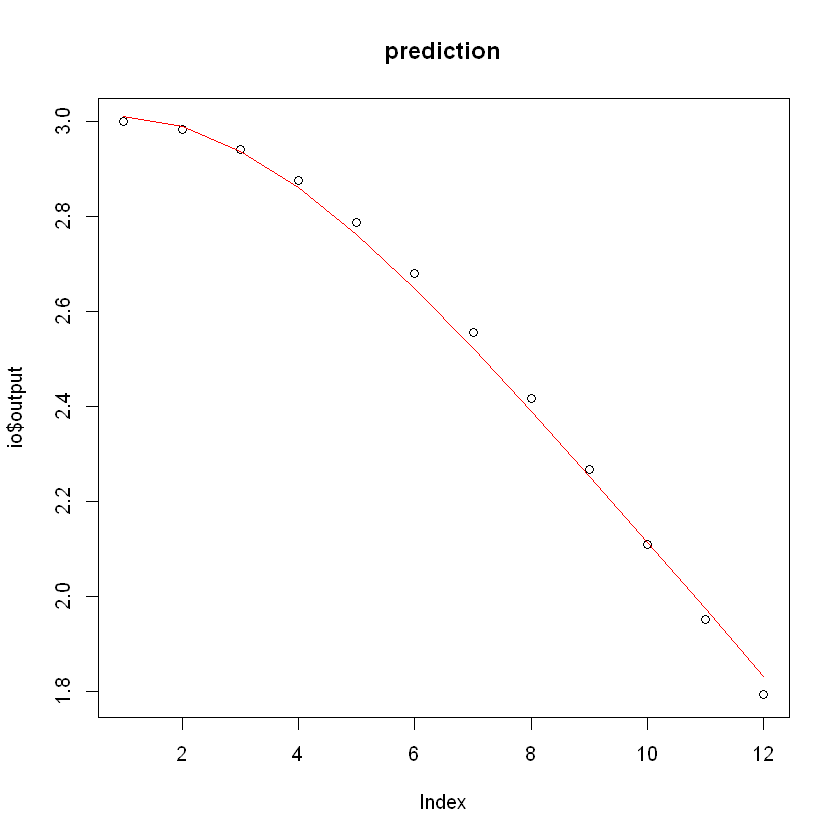

In [101]:
#plot ouput and predicted output 
plot(io$output, main="prediction")
lines(pred$x, col="red")